#  Latent Dirichlet Allocation (LDA) for Topic Modeling Report

#### LI, Xinyi (ID: 20636398) 
#### Tuesday, June 2nd, 2020

## Formal details and LDA inference

The central inferential problem for LDA is determining the posterior distribution of
the latent variables given the document:

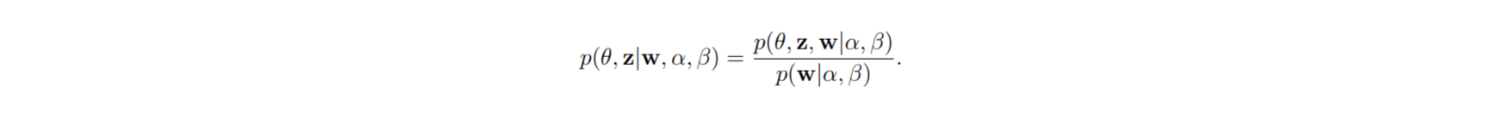


First decompose the numerator into a hierarchy by examining the graphical
model:

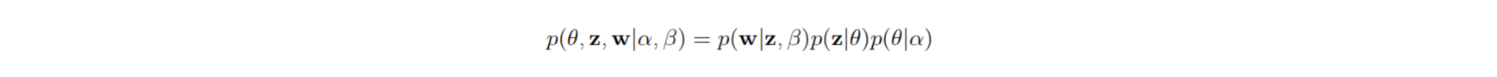

Because $p(w|z,\beta)$ represents the probability of observing a document with N words given the a topic vector of length N that assigns a topic to each word from $\beta$. So it is decomposed into the product of each individual word's probability:

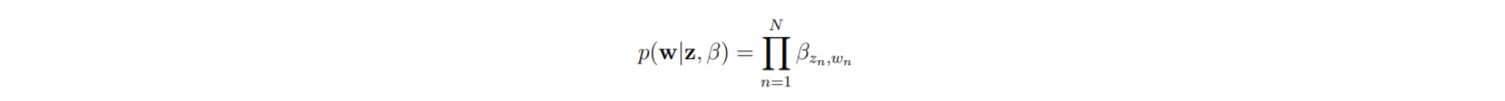

$p(z|\theta)$ is $p(z_{n}|\theta) = \theta_{i}$  such that $z_{n}^i = 1$. $p(\theta|\alpha)$ is a k dimensional multinomial given by k dimensional Dirichlet distribution.  Bringing this all together:

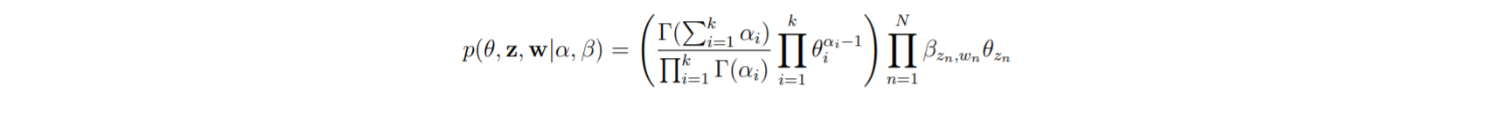

Rephrase this probability using the superscript notation, and use the entire vocabulary of size V when calculating the probability and marginalize over $\theta$ and $z$.

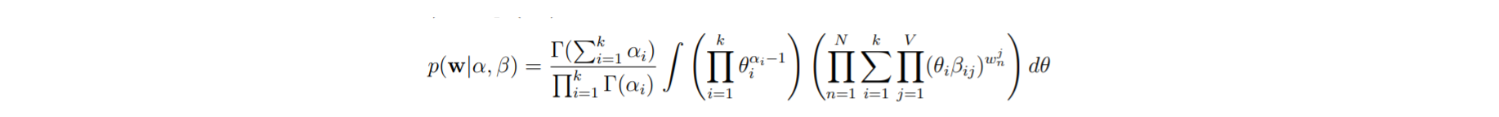


## LDA as a graphical model

The figure below displays the graphical model describing this generative process.

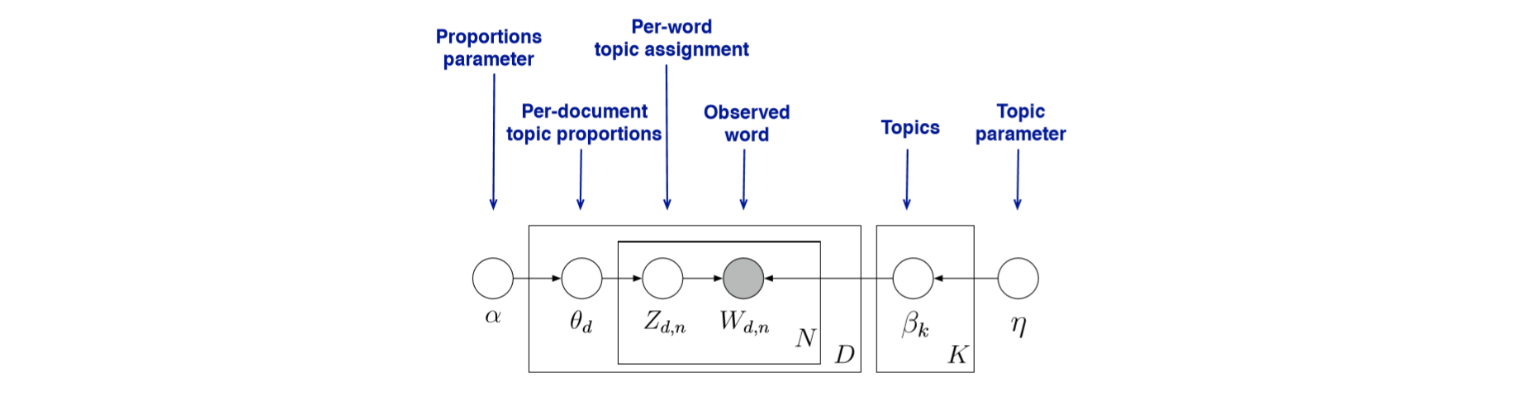

For reference purposes, first formalize some notation before moving on:

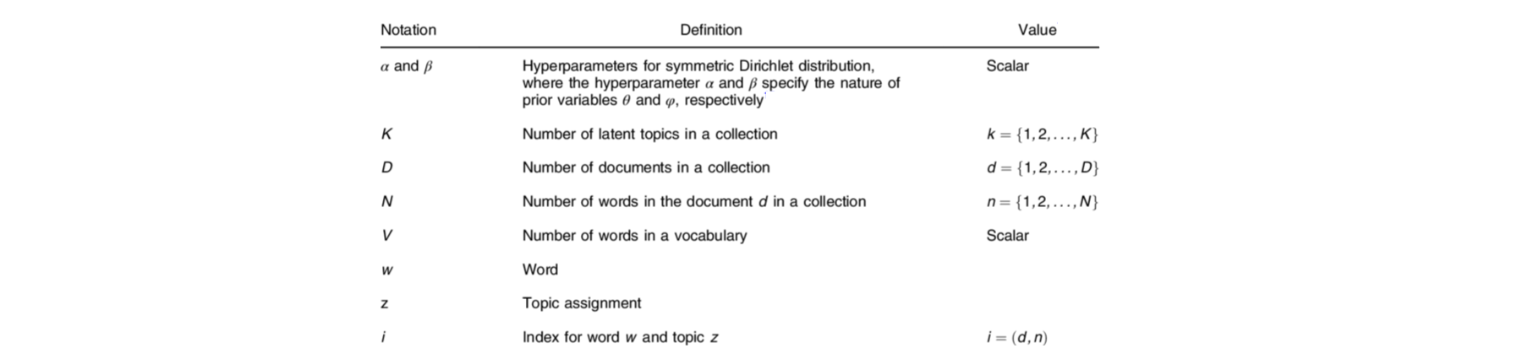



The corresponding relations of several important parameters are shown in the table below.



| Symbol in Formula  | Symbol in Code  | Description |
|--- |----------| ------|
| $\alpha$ | alpha | model parameter, hyperparameter of document-topic distribution |
| $\varphi$ | varphi | model parameter, hyperparameter of topic-word distribution |
| $\gamma$ | gamma  | inference parameter, infer per document topic proportions|
|  $\phi$  |    phi  | inference parameter, infer per word topic assignment|

### Variational Inference for LDA

The key idea of variational inference is to use a simpler distribution and get the lower bound on the log likelihood of the actual distribution. Variational parameters describe the simpler distributions and are optimized to provide the tightest possible lower bound.   
To obtain the lower bounds, the original graphical model is modified shown in the figure below.

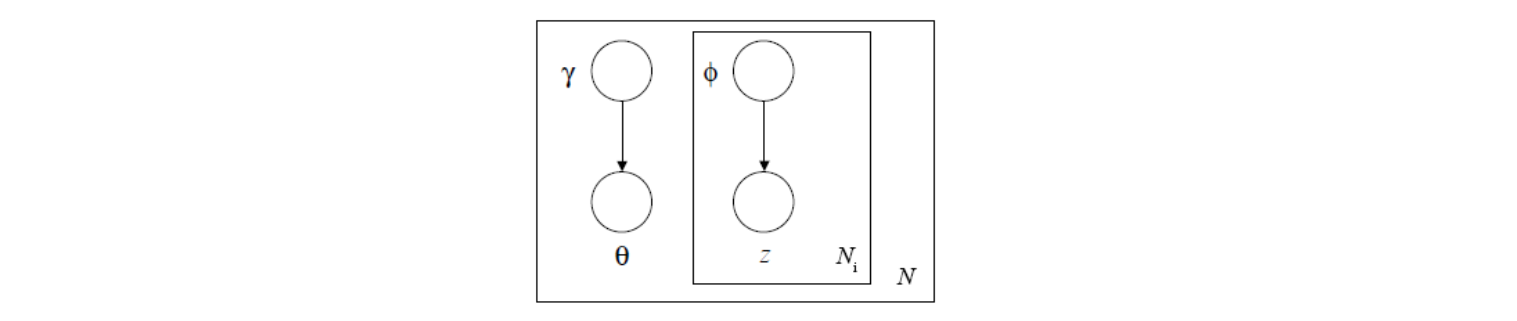

This variational distribution has a posterior for each document in
the form:

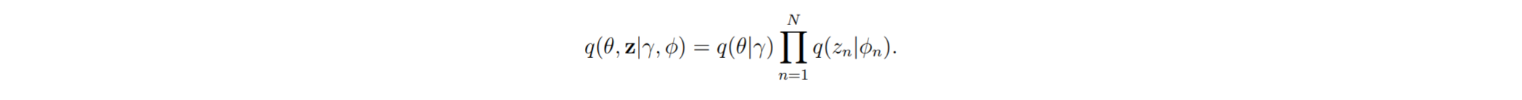

Then specify an optimization problem to find an optimal lower bound on the log likelihood and determine the values of $\gamma$ and $\phi$.



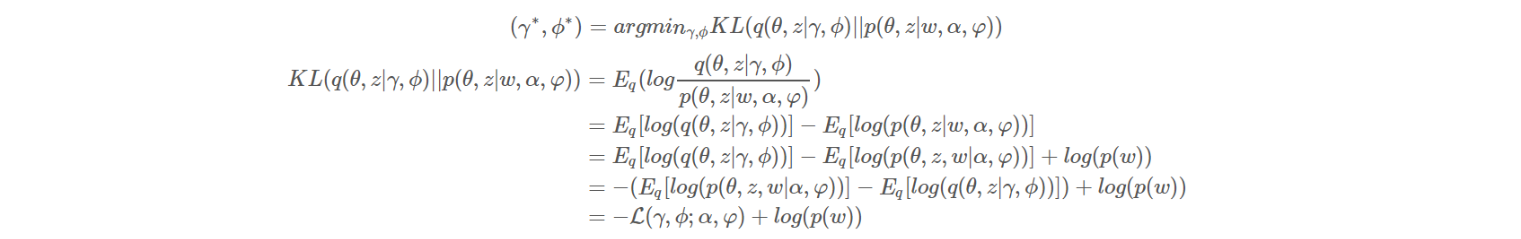

It is a minimization of the Kullback-Leibler (KL) divergence between the variational
distribution and the actual posterior distribution. Use iterative fixed-point method to minimize this function. The inference parameters are updated by the following equations:

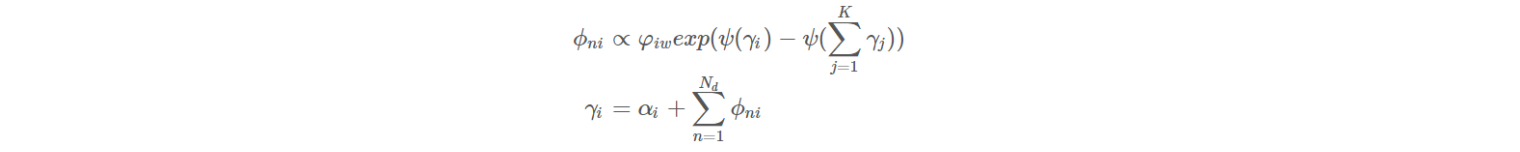




## Data Preprocessing
For text data, first extract some features for the modeling process.                                                           
wordCount : the number of total words(not terms) in a document             
itemIdList : the list of distinct terms ID in the document   
itemCountList : the list of number of the existence of corresponding terms in the document  
word2id: the 100 words in the dataset and their Ids. Key: words / Value: Id     
id2word: the 100 words in the dataset and their Ids. Key: Id / Value: words



In [6]:
import numpy as np
import codecs
import re
import random
import math
from scipy.special import psi
import pandas as pd 

data= pd.read_csv('text_data.txt', sep="\t",  header=0)
# wordCount
wordcountseries = data.sum(axis=1)
wordCount = wordcountseries.tolist() 
#  itemIdList, itemCountList
itemCountList = []
itemIdList = []
for i in range(0, 300):
    item = []
    itemcount = []
    for j in range(0, 100):
        if data.iat[i, j] !=0:
            item.append(j)
            itemcount.append(data.iat[i, j])
    itemIdList.append(item)
    itemCountList.append(itemcount)
# word2id,id2word
keys = list(data)
values = list(range(100))
word2id = dict(zip(keys, values))

keys = list(range(100))
values = list(data)
id2word = dict(zip(keys, values))

## Model Development


Then tweak the number of topic parameters for the text data.    

N: number of documents for training                         
M: number of distinct terms                                    
K: number of topic                                    
iterInference： iteration times of variational inference               
iterEM： iteration times of variational EM algorithm    
alphaSS： sufficient statistic of alpha  
varphi: the topic-word distribution (beta in D. Blei's paper)  
nzw： topic-word count, this is a sufficient statistic to calculate varphi
nz: topic count    
gamma: inference parameter   
phi: inference parameter   

The purpose of the main functions are stated below:   
updateVarphi: update model parameters varphi   
variationalInference: update variational parameters gamma and phi







In [7]:

def maxItemNum():
    num = 0
    for d in range(0, N):
        if len(itemIdList[d]) > num:
            num = len(itemIdList[d])
    return num

def initialLdaModel():
    for z in range(0, K):
        for w in range(0, M):
            nzw[z, w] += 1.0/M + random.random()
            nz[z] += nzw[z, w]
    updateVarphi()    


def updateVarphi():
    for z in range(0, K):
        for w in range(0, M):
            if(nzw[z, w] > 0):
                varphi[z, w] = math.log(nzw[z, w]) - math.log(nz[z])
            else:
                varphi[z, w] = -100
                
def variationalInference(wordCount,itemIdList,itemCountList, d, gamma, phi):
    phisum = 0
    oldphi = np.zeros([K])
    digamma_gamma = np.zeros([K])
    
    for z in range(0, K):
        gamma[d][z] = alpha + wordCount[d] * 1.0 / K
        digamma_gamma[z] = psi(gamma[d][z])
        for w in range(0, len(itemIdList[d])):
            phi[w, z] = 1.0 / K

    for iteration in range(0, iterInference):
        for w in range(0, len(itemIdList[d])):
            phisum = 0
            for z in range(0, K):
                oldphi[z] = phi[w, z]
                phi[w, z] = digamma_gamma[z] + varphi[z, itemIdList[d][w]]
                if z > 0:
                    phisum = math.log(math.exp(phisum) + math.exp(phi[w, z]))
                else:
                    phisum = phi[w, z]
            for z in range(0, K):
                phi[w, z] = math.exp(phi[w, z] - phisum)
                gamma[d][z] =  gamma[d][z] + itemCountList[d][w]  * (phi[w, z] - oldphi[z])
                digamma_gamma[z] = psi(gamma[d][z])

In [8]:
N = 300
M = 100
K = 3
iterInference = 20 
iterEM = 20
alpha = 5
alphaSS = 0
varphi = np.zeros([K, M])
nzw = np.zeros([K, M])
nz = np.zeros([K])
gamma = np.zeros([N, K])
phi = np.zeros([maxItemNum(), K])

In [9]:
initialLdaModel()

for iteration in range(0, iterEM): 
    nz = np.zeros([K])
    nzw = np.zeros([K, M])
    alphaSS = 0
    # EStep
    for d in range(0, N):
        variationalInference(wordCount,itemIdList,itemCountList, d, gamma, phi)
        gammaSum = 0
        for z in range(0, K):
            gammaSum += gamma[d, z]
            alphaSS += psi(gamma[d, z])
        alphaSS -= K * psi(gammaSum)

        for w in range(0, len(itemIdList[d])):
            for z in range(0, K):
                nzw[z][itemIdList[d][w]] +=itemCountList[d][w]  * phi[w, z]
                nz[z] += itemCountList[d][w]  * phi[w, z]

    # MStep
    updateVarphi()

In [10]:
topic_doc = []
for d in range(0, N):
    theta = sum(gamma[d])
    theta_1 = gamma[d][0]/theta
    theta_2 = gamma[d][1]/theta
    theta_3 = gamma[d][2]/theta
    theta_update = [theta_1,theta_2,theta_3]
    topic_doc.append(theta_update)
df = pd.DataFrame(topic_doc) 
df.T      


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.746139,0.134458,0.087459,0.461841,0.743517,0.660999,0.228998,0.469989,0.672426,0.042471,...,0.495055,0.330364,0.046160,0.042584,0.384379,0.530637,0.069211,0.074274,0.055439,0.673501
1,0.067810,0.798960,0.851959,0.060719,0.199490,0.153726,0.681964,0.446753,0.250209,0.884753,...,0.064743,0.599137,0.907650,0.781569,0.065297,0.332113,0.851404,0.447772,0.907564,0.062917
2,0.186051,0.066582,0.060581,0.477440,0.056993,0.185274,0.089038,0.083258,0.077365,0.072777,...,0.440202,0.070499,0.046189,0.175848,0.550324,0.137250,0.079386,0.477953,0.036997,0.263582


## Compare with True Topic Distribution of Documents  


As shown in the table, the result of LDA algorithm match the true distribution very well, correctly assigning the documents to the topics. 

In [11]:
true_distribution = pd.read_csv('topic_doc_true.txt', sep="\t",  header=None)
true_distri_sort = true_distribution
true_distri_sort.reindex([2,0,1])

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
2,0.869536,0.098986,0.041510,0.494721,0.830230,0.714680,0.176563,0.558522,0.684895,0.005617,...,0.444708,0.388454,0.005499,0.007087,0.361400,0.570541,0.034923,0.000009,0.009026,0.736356
0,0.112215,0.013516,0.030768,0.504802,0.011048,0.215036,0.016316,0.025260,0.049396,0.042949,...,0.512006,0.038747,0.001235,0.129598,0.621283,0.081268,0.015350,0.610135,0.000345,0.263451
1,0.018249,0.887499,0.927722,0.000477,0.158722,0.070284,0.807121,0.416218,0.265709,0.951434,...,0.043286,0.572799,0.993265,0.863315,0.017317,0.348191,0.949727,0.389857,0.990630,0.000193


##  Apply to Real Dataset

In [12]:
cora = pd.read_csv('cora_data.txt', sep="\t",  header='infer')

# number of document
N = 2407
# number of distinct term
M = 2961
# number of topic
K = 8

# wordCount
wordcountseries = cora.sum(axis=1)
wordCount = wordcountseries.tolist() 

#  itemIdList, itemCountList
itemCountList = []
itemIdList = []
for i in range(0, N):
    item = []
    itemcount = []
    for j in range(0, M):
        if cora.iat[i, j] !=0:
            item.append(j)
            itemcount.append(cora.iat[i, j])
    itemIdList.append(item)
    itemCountList.append(itemcount)

# word2id,id2word
keys = list(cora)
values = list(range(M))
word2id = dict(zip(keys, values))

keys = list(range(M))
values = list(cora)
id2word = dict(zip(keys, values))


In [13]:
def maxItemNum():
    num = 0
    for d in range(0, N):
        if len(itemIdList[d]) > num:
            num = len(itemIdList[d])
    return num

def initialLdaModel():
    for z in range(0, K):
        for w in range(0, M):
            nzw[z, w] += 1.0/M + random.random()
            nz[z] += nzw[z, w]
    updateVarphi()    

# update model parameters : varphi (the update of alpha is ommited)
def updateVarphi():
    for z in range(0, K):
        for w in range(0, M):
            if(nzw[z, w] > 0):
                varphi[z, w] = math.log(nzw[z, w]) - math.log(nz[z])
            else:
                varphi[z, w] = -100

def variationalInference(wordCount,itemIdList,itemCountList, d, gamma, phi):
    phisum = 0
    oldphi = np.zeros([K])
    digamma_gamma = np.zeros([K])
    
    for z in range(0, K):
        gamma[d][z] = alpha + wordCount[d] * 1.0 / K
        digamma_gamma[z] = psi(gamma[d][z])
        for w in range(0, len(itemIdList[d])):
            phi[w, z] = 1.0 / K

    for iteration in range(0, iterInference):
        for w in range(0, len(itemIdList[d])):
            phisum = 0
            for z in range(0, K):
                oldphi[z] = phi[w, z]
                phi[w, z] = digamma_gamma[z] + varphi[z, itemIdList[d][w]]
                if z > 0:
                    phisum = math.log(math.exp(phisum) + math.exp(phi[w, z]))
                else:
                    phisum = phi[w, z]
            for z in range(0, K):
                phi[w, z] = math.exp(phi[w, z] - phisum)
                gamma[d][z] =  gamma[d][z] + itemCountList[d][w]  * (phi[w, z] - oldphi[z])
                digamma_gamma[z] = psi(gamma[d][z])


In [14]:
iterInference = 20 
iterEM = 20
alpha = 5
alphaSS = 0
varphi = np.zeros([K, M])
nzw = np.zeros([K, M])
nz = np.zeros([K])
gamma = np.zeros([N, K])
phi = np.zeros([maxItemNum(), K])

In [15]:
initialLdaModel()

for iteration in range(0, iterEM): 
    nz = np.zeros([K])
    nzw = np.zeros([K, M])
    alphaSS = 0
    # EStep
    for d in range(0, N):
        variationalInference(wordCount,itemIdList,itemCountList, d, gamma, phi)
        gammaSum = 0
        for z in range(0, K):
            gammaSum += gamma[d, z]
            alphaSS += psi(gamma[d, z])
        alphaSS -= K * psi(gammaSum)

        for w in range(0, len(itemIdList[d])):
            for z in range(0, K):
                nzw[z][itemIdList[d][w]] +=itemCountList[d][w]  * phi[w, z]
                nz[z] += itemCountList[d][w]  * phi[w, z]

    # MStep
    updateVarphi()

In [16]:
topic_doc = []
for d in range(0, N):
    theta_update = []
    for z in range(0, K): 
        theta_1 = gamma[d][z]/sum(gamma[d])
        theta_update.append(theta_1)
    topic_doc.append(theta_update)
    
df = pd.DataFrame(topic_doc) 
df.T 

,0,1,2,3,4,5,6,7,8,9,...,2397,2398,2399,2400,2401,2402,2403,2404,2405,2406
0,0.087205,0.143669,0.096496,0.094764,0.097711,0.126119,0.097979,0.114123,0.057245,0.087817,...,0.081996,0.089273,0.088477,0.087728,0.081255,0.045554,0.235886,0.097577,0.277970,0.115559
1,0.173196,0.071004,0.089907,0.155308,0.345005,0.228216,0.081023,0.169958,0.087117,0.178093,...,0.177344,0.218001,0.362638,0.099032,0.124075,0.074376,0.084419,0.085839,0.101640,0.081476
2,0.151140,0.097153,0.131246,0.292393,0.091501,0.103479,0.102914,0.106633,0.085839,0.100679,...,0.056506,0.072323,0.086227,0.210341,0.122424,0.074116,0.130000,0.149700,0.090467,0.116985
3,0.180608,0.108368,0.068855,0.057548,0.134584,0.076722,0.063575,0.102907,0.060798,0.203790,...,0.057918,0.069808,0.088505,0.087114,0.146653,0.050920,0.087548,0.069837,0.120405,0.143899
4,0.165434,0.155935,0.085132,0.103484,0.130695,0.155629,0.109506,0.145381,0.450131,0.145340,...,0.404683,0.242057,0.109634,0.101551,0.077442,0.059460,0.090326,0.217995,0.074594,0.173330
5,0.075146,0.077686,0.308604,0.140795,0.061551,0.086714,0.202469,0.083801,0.056283,0.083857,...,0.069905,0.095426,0.086430,0.186383,0.176117,0.065187,0.080268,0.109169,0.117347,0.175604
6,0.105813,0.134524,0.158891,0.111774,0.061340,0.086350,0.138634,0.152735,0.070610,0.091363,...,0.058138,0.074684,0.090289,0.085577,0.148981,0.583765,0.169391,0.179778,0.118501,0.085991
7,0.061459,0.211659,0.060869,0.043934,0.077613,0.136771,0.203900,0.124462,0.131977,0.109062,...,0.093511,0.138427,0.087801,0.142275,0.123053,0.046622,0.122162,0.090105,0.099075,0.107155


In [18]:
# calculate the top 10 terms of each topic
topicwords = []
maxTopicWordsNum = 10
for z in range(0, K):
	ids = varphi[z, :].argsort()
	topicword = []
	for j in ids:
		topicword.insert(0, id2word[j])
	topicwords.append(topicword[0 : min(10, len(topicword))])

df = pd.DataFrame(topicwords) 
df 

,0,1,2,3,4,5,6,7,8,9
0,performance,design,approach,paper,describe,techniques,process,systems,system,previous
1,algorithm,algorithms,method,methods,distribution,optimal,probability,state,markov,convergence
2,network,theory,time,paper,systems,control,problems,test,training,based
3,neural,networks,models,model,data,research,functions,analysis,hidden,series
4,model,decision,number,show,classification,results,training,algorithm,examples,data
5,system,learning,knowledge,case,task,representation,paper,learn,architecture,memory
6,problem,genetic,search,space,features,approach,problems,feature,programming,algorithm
7,learning,paper,results,method,machine,bayesian,concept,dynamic,parallel,show


The first data frame shows topic proportions of each document. The second shows the top 10 words in each of the topic.  
Some topics look the same because:  
(1) Hyperparameter $\alpha$ is set default value and not updated in the M-step.     
(2) Data cleaning is not thoroughly implemented. As shown in the top words, "algorithm" and "algorithm" exist at the same time. In order to improve the efficiency of text processing, normalized text should be used. Plural form of each word need to be converted into the singular form. All words'tense should be turned to the present.   
(3) Hyperparameter tuning should be implemented. The following model hyperparameters should be optimized:   
Number of Topics (K)  
Dirichlet hyperparameter $\alpha$: Document-Topic Density  
Dirichlet hyperparameter $\beta$: Word-Topic Density

In this case, we'll try different settings and compare the results.
To have a more sparse distribution, and let documents be less similar and more specifit in terms of what topics they contain, we will use a smaller $\alpha$. 







In [19]:
import numpy as np
import codecs
import re
import random
import math
from scipy.special import psi
import pandas as pd 

cora = pd.read_csv('cora_data.txt', sep="\t",  header='infer')

In [20]:
N = 2407
# number of distinct terms 
M = 2961
# number of topic
K = 5
wordcountseries = cora.sum(axis=1)
wordCount = wordcountseries.tolist() 
#  itemIdList, itemCountList
itemCountList = []
itemIdList = []
for i in range(0, N):
    item = []
    itemcount = []
    for j in range(0, M):
        if cora.iat[i, j] !=0:
            item.append(j)
            itemcount.append(cora.iat[i, j])
    itemIdList.append(item)
    itemCountList.append(itemcount)


In [21]:
# word2id,id2word
keys = list(cora)
values = list(range(M))
word2id = dict(zip(keys, values))

keys = list(range(M))
values = list(cora)
id2word = dict(zip(keys, values))


In [22]:
def maxItemNum():
    num = 0
    for d in range(0, N):
        if len(itemIdList[d]) > num:
            num = len(itemIdList[d])
    return num

def initialLdaModel():
    for z in range(0, K):
        for w in range(0, M):
            nzw[z, w] += 1.0/M + random.random()
            nz[z] += nzw[z, w]
    updateVarphi()    

# update model parameters : varphi (the update of alpha is ommited)
def updateVarphi():
    for z in range(0, K):
        for w in range(0, M):
            if(nzw[z, w] > 0):
                varphi[z, w] = math.log(nzw[z, w]) - math.log(nz[z])
            else:
                varphi[z, w] = -100


In [23]:
def variationalInference(wordCount,itemIdList,itemCountList, d, gamma, phi):
    phisum = 0
    oldphi = np.zeros([K])
    digamma_gamma = np.zeros([K])
    
    for z in range(0, K):
        gamma[d][z] = alpha + wordCount[d] * 1.0 / K
        digamma_gamma[z] = psi(gamma[d][z])
        for w in range(0, len(itemIdList[d])):
            phi[w, z] = 1.0 / K

    for iteration in range(0, iterInference):
        for w in range(0, len(itemIdList[d])):
            phisum = 0
            for z in range(0, K):
                oldphi[z] = phi[w, z]
                phi[w, z] = digamma_gamma[z] + varphi[z, itemIdList[d][w]]
                if z > 0:
                    phisum = math.log(math.exp(phisum) + math.exp(phi[w, z]))
                else:
                    phisum = phi[w, z]
            for z in range(0, K):
                phi[w, z] = math.exp(phi[w, z] - phisum)
                gamma[d][z] =  gamma[d][z] + itemCountList[d][w]  * (phi[w, z] - oldphi[z])
                digamma_gamma[z] = psi(gamma[d][z])

In [24]:
iterInference = 20 
iterEM = 20
alpha = 0.5
alphaSS = 0
varphi = np.zeros([K, M])
nzw = np.zeros([K, M])
nz = np.zeros([K])
gamma = np.zeros([N, K])
phi = np.zeros([maxItemNum(), K])


In [25]:
initialLdaModel()
for iteration in range(0, iterEM): 
    nz = np.zeros([K])
    nzw = np.zeros([K, M])
    alphaSS = 0
    # EStep
    for d in range(0, N):
        variationalInference(wordCount,itemIdList,itemCountList, d, gamma, phi)
        gammaSum = 0
        for z in range(0, K):
            gammaSum += gamma[d, z]
            alphaSS += psi(gamma[d, z])
        alphaSS -= K * psi(gammaSum)

        for w in range(0, len(itemIdList[d])):
            for z in range(0, K):
                nzw[z][itemIdList[d][w]] +=itemCountList[d][w]  * phi[w, z]
                nz[z] += itemCountList[d][w]  * phi[w, z]

    # MStep
    updateVarphi()

In [26]:
topic_doc = []
for d in range(0, N):
    theta_update = []
    for z in range(0, K): 
        theta_1 = gamma[d][z]/sum(gamma[d])
        theta_update.append(theta_1)
    topic_doc.append(theta_update)

In [27]:
df = pd.DataFrame(topic_doc) 
df.T 

,0,1,2,3,4,5,6,7,8,9,...,2397,2398,2399,2400,2401,2402,2403,2404,2405,2406
0,0.093385,0.241258,0.229177,0.562742,0.011588,0.049467,0.359494,0.028019,0.007645,0.020671,...,0.008160,0.016754,0.023664,0.025015,0.235299,0.644442,0.339428,0.796172,0.714440,0.015605
1,0.144023,0.011441,0.355857,0.037072,0.040737,0.014444,0.010013,0.022397,0.007115,0.377106,...,0.008318,0.010075,0.025023,0.504980,0.601614,0.024575,0.060477,0.012030,0.237851,0.375244
2,0.739483,0.122402,0.078990,0.169024,0.929666,0.250898,0.038092,0.839686,0.712548,0.558397,...,0.497408,0.519861,0.903386,0.020139,0.015531,0.190705,0.084476,0.016229,0.018874,0.045542
3,0.015883,0.015432,0.329762,0.226170,0.009376,0.015179,0.085112,0.083300,0.006951,0.021011,...,0.008110,0.038845,0.023859,0.059002,0.032317,0.006447,0.258686,0.012162,0.014770,0.083909
4,0.007227,0.609466,0.006214,0.004992,0.008633,0.670012,0.507288,0.026598,0.265742,0.022815,...,0.478005,0.414465,0.024068,0.390863,0.115239,0.133830,0.256933,0.163407,0.014066,0.479699


In [28]:
# calculate the top 10 terms of each topic
topicwords = []
maxTopicWordsNum = 10
for z in range(0, K):
	ids = varphi[z, :].argsort()
	topicword = []
	for j in ids:
		topicword.insert(0, id2word[j])
	topicwords.append(topicword[0 : min(10, len(topicword))])

topicwords
tw_df = pd.DataFrame(topicwords) 
tw_df 

,0,1,2,3,4,5,6,7,8,9
0,problem,genetic,system,paper,knowledge,search,approach,design,reasoning,problems
1,network,neural,networks,model,data,time,input,models,structure,analysis
2,algorithm,model,function,algorithms,results,distribution,show,number,bayesian,error
3,research,control,paper,systems,report,system,parallel,models,learning,grant
4,learning,algorithm,training,algorithms,paper,results,method,decision,performance,examples


The topic become more clear and separate. The 5 topics can be summarized as: learning, algorithm, system, biology, neural network.